In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller

### Problem

In this project, we'll be predicting FTSE 100 values.

 We will use daily closing FTSE 100 values from 2021-09-27 (Monday) to 2025-09-19 (Friday) from the yfinance library.




In [38]:
# obtaining FTSE 100 values from yfinance
FTSE_100_df = yfinance.download("^FTSE", start="2021-09-25", end="2025-09-19")
print(FTSE_100_df.head(10))  # displays close, High, Low, Open, and Volume - want only close.
FTSE_100_closing_df = FTSE_100_df['Close']
FTSE_100_closing_df.columns = ['Close']
print(FTSE_100_closing_df.head())

C:\Users\samue\AppData\Local\Temp\ipykernel_46012\1663075967.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  FTSE_100_df = yfinance.download("^FTSE", start="2021-09-25", end="2025-09-19")
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open     Volume
Ticker            ^FTSE        ^FTSE        ^FTSE        ^FTSE      ^FTSE
Date                                                                     
2021-09-27  7063.399902  7122.100098  7043.200195  7051.500000  900413700
2021-09-28  7028.100098  7071.399902  7015.600098  7063.399902  819400500
2021-09-29  7108.200195  7117.500000  7026.899902  7028.100098  810850000
2021-09-30  7086.399902  7159.600098  7072.600098  7108.200195  868050200
2021-10-01  7027.100098  7086.399902  6989.600098  7086.399902  815417000
2021-10-04  7011.000000  7072.500000  7002.700195  7027.100098  792854800
2021-10-05  7077.100098  7084.500000  7011.000000  7011.000000  846145500
2021-10-06  6995.899902  7077.100098  6945.500000  7077.100098  944014100
2021-10-07  7078.000000  7094.899902  6995.899902  6995.899902  709629100
2021-10-08  7095.600098  7109.299805  7070.500000  7078.000000  707356500
                  Close
Date          

Since we are only interested in using closing FTSE 100 values, we have removed the other columns from the dataframe. 

It is important that we make the distinction between day and trading day. Obviously, the FTSE 100 only shows values for trading days: it is traded on week days excluding holidays. One might be concerned that the difference between closing FTSE 100 values on consecutive DAYs may be different to the difference in FTSE 100 values on consecutive TRADING DAYs that aren't consecutive DAYs. Actually, there isn't much of a difference, which we can show as follows:

In [39]:
# We wish to calculate abs(C_t - C_{t-1}) for t = 1, ..., len(trading_days)
# Each time we calculate this we note whether consecutive trading days are consecutive days (True) or not (False)

# Creating a dataframe that pairs together current closing FTSE 100 values with previous trading day values and includes their differences
FTSE_100_closing_values_t = pd.DataFrame(FTSE_100_closing_df.values)
FTSE_100_closing_values_t_minus_1 = FTSE_100_closing_values_t.shift(1)
FTSE_100_differences = pd.concat([FTSE_100_closing_values_t_minus_1, FTSE_100_closing_values_t], axis=1)
FTSE_100_differences.columns = ['t-1', 't']
FTSE_100_differences['abs(C_t - C_{t-1})'] = abs(FTSE_100_differences['t'] - FTSE_100_differences['t-1']) # only interested in absolute differences at this stage
print(FTSE_100_differences.head(10))

# We then add a fourth column telling us whether the pairs of trading days are on consecutive days or not
trading_days_t = pd.Series(FTSE_100_closing_df.index)
trading_days_t_minus_1 = trading_days_t.shift(1)
consecutive_days = (trading_days_t - trading_days_t_minus_1).dt.days == 1

FTSE_100_differences['consecutive days (True/False)'] = consecutive_days

mean_difference_consec = FTSE_100_differences[FTSE_100_differences['consecutive days (True/False)']]['abs(C_t - C_{t-1})'].mean()
mean_difference_nonconsec = FTSE_100_differences[FTSE_100_differences['consecutive days (True/False)'] == False]['abs(C_t - C_{t-1})'].mean()

print(FTSE_100_differences.head())

print(f'mean absolute difference on consecutive days: {mean_difference_consec}')
print(f'mean absolute difference on non-consecutive days: {mean_difference_nonconsec}')


           t-1            t  abs(C_t - C_{t-1})
0          NaN  7063.399902                 NaN
1  7063.399902  7028.100098           35.299805
2  7028.100098  7108.200195           80.100098
3  7108.200195  7086.399902           21.800293
4  7086.399902  7027.100098           59.299805
5  7027.100098  7011.000000           16.100098
6  7011.000000  7077.100098           66.100098
7  7077.100098  6995.899902           81.200195
8  6995.899902  7078.000000           82.100098
9  7078.000000  7095.600098           17.600098
           t-1            t  abs(C_t - C_{t-1})  consecutive days (True/False)
0          NaN  7063.399902                 NaN                          False
1  7063.399902  7028.100098           35.299805                           True
2  7028.100098  7108.200195           80.100098                           True
3  7108.200195  7086.399902           21.800293                           True
4  7086.399902  7027.100098           59.299805                           Tru

The two averages are very close together, which suggests that trading days is a suitable time index

### Test Harness
In time series forecasting, a test harness is a way of evaluating forecasting models in a consistent manner. The process of making a test harness is divided into two steps:

1: Making a validation set.
We first need to define a validation set. A validation set is what we use to compare the predictions made by the final chosen model. How long should our validation set be? This is an important question to ask.
If it is too long, then the models we use may include out-dated market conditions. For example, if we train our model on FTSE data from 2021–2022 when volatility was high, then validate on 2023–2025 when volatility decreased, the model may no longer reflect current market conditions. It would be pointless to validate the model on values observed too long after the data the model was trained with.
If it is too short, then we won't have enough data to reliably measure performance. For our project, we will make the validation set length 9 months, that is roughly 198 trading days.
The first step of making a test harness is outlined below:








In [40]:
# Creating train and validation sets
n_trading_days = len(FTSE_100_df)
split_point = n_trading_days - 198 
present_trading_day = trading_days_t[split_point]
print(f'present trading day: {present_trading_day}')  # We will pretend that 2024-12-05 is the present day.
FTSE_100_train, FTSE_100_validation = FTSE_100_closing_df[0: split_point], FTSE_100_closing_df[split_point:]
print(f'train length : {len(FTSE_100_train)}, validation length: {len(FTSE_100_validation)}')

present trading day: 2024-12-05 00:00:00
train length : 806, validation length: 198


2: Model evaluation.
We then need to decide on a performance measure(s) and a test strategy.

Performance measures: there are loads to chose from, including root mean squared error (RMSE) and mean absolute error (MAE). For our project, we'll use RMSE.
test strategy:
We will evaluate candidate models using walk-forward validation. This is because a rolling-forecast type of model is required from the problem definition (*). The walk-forward validation will work as follows:<br>
a: Use first 90% of the dataset to train the model.<br>
b: Iterate over the remaining part of the dataset to test the model. <br>
c: for each step of the test dataset:<br>
(a) A model will be trained <br>
(b) A one-step prediction for closing FTSE 100 index made which is then stored for evaluation <br>
(c) The actual observed FTSE 100 index from the test dataset will be added to the training dataset for the next iteration. <br>
Below we create a returns dataframe and prepare our data for walk-forward validation

In [92]:
print(FTSE_100_closing_df.head())
FTSE_100_closing_df = FTSE_100_closing_df[:split_point]
# creating FTSE 100 closing values series
FTSE_100_closing_series = pd.Series(FTSE_100_closing_df['Close'])
# creating train set and test set for walk-forward validation
train_size = int(len(FTSE_100_closing_series) * 0.90)
train, test = FTSE_100_closing_series[0:train_size].values, FTSE_100_closing_series[train_size:].values
print()
print(f'train set:\n {train[:5]}')
print()
print(f'test set:\n {test[:5]}')

                  Close
Date                   
2021-09-27  7063.399902
2021-09-28  7028.100098
2021-09-29  7108.200195
2021-09-30  7086.399902
2021-10-01  7027.100098

train set:
 [7063.39990234 7028.10009766 7108.20019531 7086.39990234 7027.10009766]

test set:
 [8235.20019531 8281.09960938 8347.40039062 8311.40039062 8356.90039062]


A good baseline model for any time series forecasting problem is the persistence model. The persistence model uses the value at the current time step to predict the value at the next time step. Its simplicity makes it a good reference point for model comparison.

In [84]:
# Walk-forward validation
history = list(train)
predictions = []
test_length = len(test)
for i in range(test_length):
    # predict the next daily closing FTSE 100 using persistence model
    # this is simply the last element of history, which is the value
    # at the current time step
    yhat = history[-1]
    predictions.append(yhat)
    # add the actual observed value to history so that the model can be retrained
    history.append(test[i])
# Report performance
print(test[:10])
print(predictions[:10])
# Root mean squared error
rmse = sqrt(mean_squared_error(test, predictions))
print(f'RMSE : {rmse}') # sqrt(np.sum((test-np.array(predictions))**2)/(test_length))

[8243.70019531 8237.70019531 8253.70019531 8292.70019531 8249.29980469
 8329.09960938 8385.09960938 8358.29980469 8318.20019531 8306.5       ]
[np.float64(8190.60009765625), np.float64(8243.7001953125), np.float64(8237.7001953125), np.float64(8253.7001953125), np.float64(8292.7001953125), np.float64(8249.2998046875), np.float64(8329.099609375), np.float64(8385.099609375), np.float64(8358.2998046875), np.float64(8318.2001953125)]
RMSE : 44.85280059847221


### Data Analysis

Some statistical models used for time series forecasting, such as the ARIMA model, require that the time series is stationary. This means that it must exhibit no trend and no seasonality. To determine whether the closing FTSE 100 time series in stationary informally, we can make use of line plots and histograms along with summary statistics.

Date
2021-12-31    7226.785286
2022-12-31    7357.437607
2023-12-31    7615.489260
2024-12-31    8067.281444
Freq: YE-DEC, Name: Close, dtype: float64
Date
2021-12-31    11173.399189
2022-12-31    41221.576863
2023-12-31    33128.576108
2024-12-31    73354.545308
Freq: YE-DEC, Name: Close, dtype: float64


Text(0, 0.5, 'frequency')

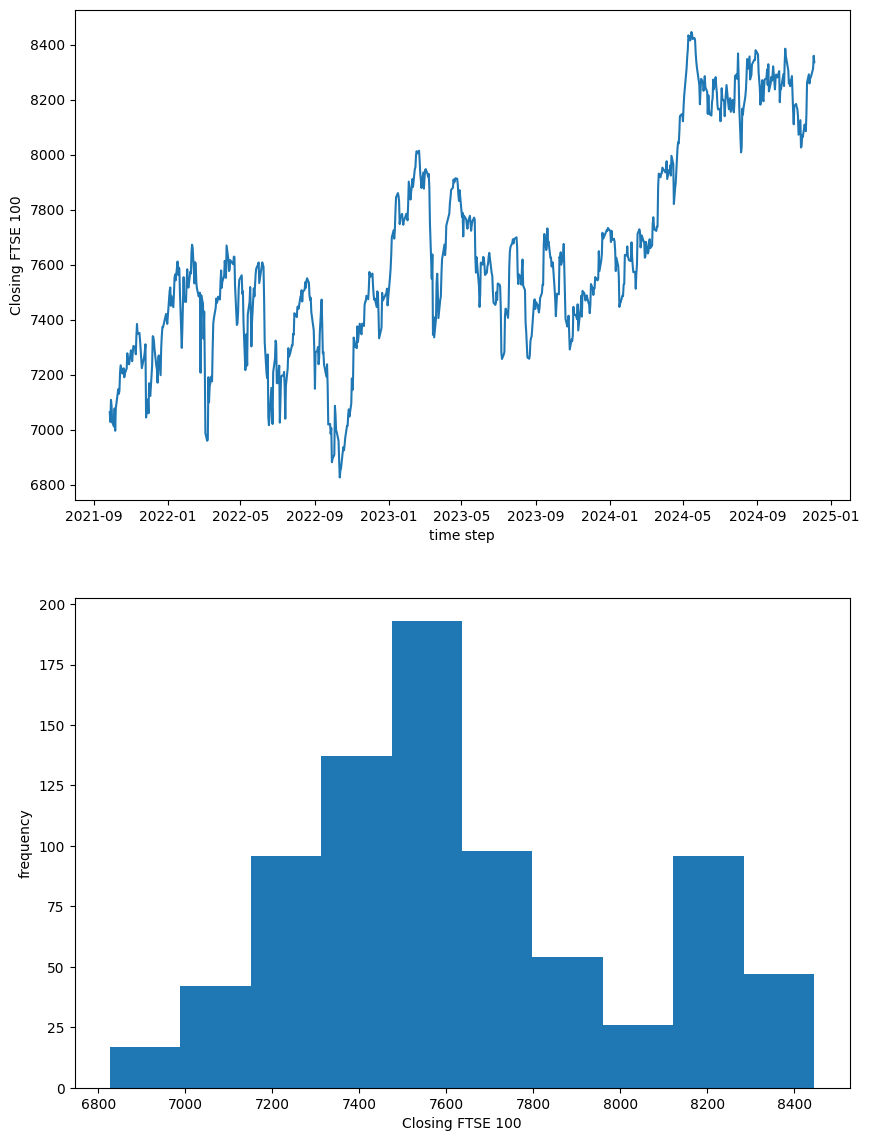

In [85]:
# Making use of summary statistics

groups = FTSE_100_closing_series.groupby(pd.Grouper(freq='YE'))
annual_var = groups.var()
annual_var.columns = ['variance']
annual_mean = groups.mean()
annual_mean.columns = ['mean']
print(annual_mean)
print(annual_var)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))
ax1.plot(FTSE_100_closing_series) # line plot
ax2.hist(FTSE_100_closing_series)
ax1.set_xlabel('time step')
ax1.set_ylabel('Closing FTSE 100')
ax2.set_xlabel('Closing FTSE 100')
ax2.set_ylabel('frequency')

The line plot appears to show a positive trend. Moreover, the distribution given by the histogram appears to be positively skewed and not Gaussian. This would suggest that the time series is non-stationary. The best way of determining if the time series is stationary is by using the Augmented Dickey-Fuller (ADF) test. This a type of unit root test. If the series has a unit root, it is non-stationary and if it doesn't, it is stationary. <br>
$ H_{0}:$ The series has a unit root <br>
$ H_{1}:$ The series does not have a unit root. <br>
We reject $H_{0}$ at the $\alpha$% significance level if ADF statistic < critical value at chosen $\alpha$.
Suppose we test the hypothesis at the 5% significance level. The ADF statistic and critical value at the 5% significance level are found below.

In [86]:
# ADF test on the daily returns data not for validation
result = adfuller(FTSE_100_closing_series)
print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{(key, value)}')

ADF statistic: -2.186930406635075
p-value: 0.21102311485497172
Critical Values:
('1%', np.float64(-3.4384994096285393))
('5%', np.float64(-2.8651370452361107))
('10%', np.float64(-2.56868539060993))


Since -2.1869... > -2.864425... we accept $H_0$ and conclude that there is sufficient evidence to suggest that the time series is non-stationary.

### ARIMA models

We will now fit an ARIMA model with the FTSE 100 data.
ARIMA stands for autoregressive integrated moving average model. The acronym consists of the key aspects of the model. <br><br>
AR: Autoregression. An autoregression model uses the dependent relationship between an observation and some number of lagged observations.<br><br>
I: Integrated. The use of differencing of raw observations to make the time series stationary (which ours already is!) <br><br>
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. <br>
Hence the ARIMA model has three parameters: <br><br>
p: The number of lag observations included in the model (lag order)<br>
d: The number of times we difference the raw observations<br>
q: The size of the moving average window (order of moving average)<br><br>
Since our time series is non-stationary, $d>=1$!




### Finding p, d and q
We can find p and q by reviewing the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. 

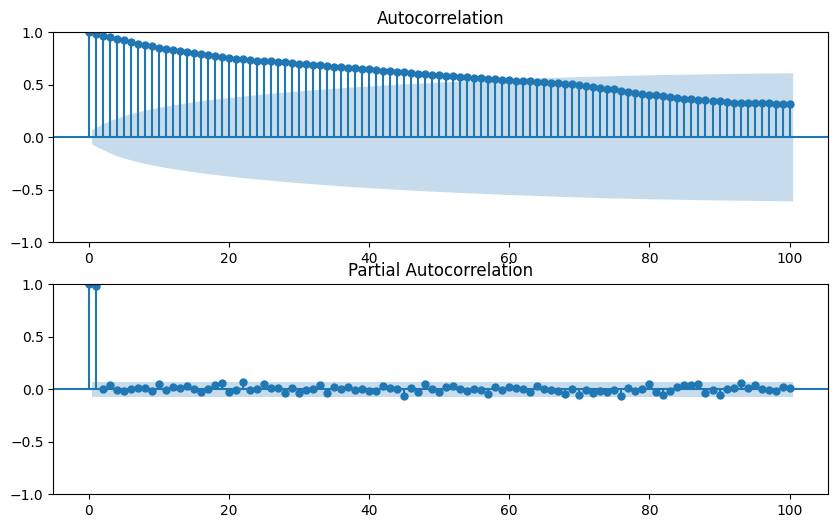

In [87]:
# ACF and PACF plots of time series

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(FTSE_100_closing_df, lags=100, ax=ax1)
plot_pacf(FTSE_100_closing_df, lags=100, ax=ax2)

plt.show()

We use the autocorrelation plot to determine p. The shaded region gives 95% confidence intervals for autocorrelations between observations and lag observations k trading days ago (0 <= k <= 100). Each CI is constructed under the null hypothesis that the series is white noise. If the autocorrelation lies outside the CI, then it is significant. From the plot we can see that autocorrelations for the fist 75 lags are significant, hence we wish to include these lag values in the AR part of the model, so we set $p=57$ <br><br>
We use the partial autocorrelation plot to determine q in a similat way, and we set $q=2$<br><br>
now we determine d:

In [88]:
# Create differenced time series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

# Difference FTSE 100 series
stationary = difference(FTSE_100_closing_series)
print(stationary.head())

# We use the ADF test on this differenced time series to check if it is stationary
# at the 5% significance level
result = adfuller(stationary)
print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'{(key, value)}')


0   -35.299805
1    80.100098
2   -21.800293
3   -59.299805
4   -16.100098
dtype: float64
ADF statistic: -29.275518127770116
p-value: 0.0
Critical Values:
('1%', np.float64(-3.4385095783477877))
('5%', np.float64(-2.865141527500859))
('10%', np.float64(-2.5686877783346946))


C:\Users\samue\AppData\Local\Temp\ipykernel_46012\495121334.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = dataset[i] - dataset[i-1]


Since ADF statistic = -29.2755.. < -2.8651.. = critical value, we reject $H_0$ at the 5% significance level and conclude sufficent evidence to suggest that the differenced time series (which is actually daily returns) is stationary. We therefore set $d=1$.<br><br>
Our manually configured ARIMA model is ARIMA(57, 1, 2), which we will now fit with our data.

46.208209532361906


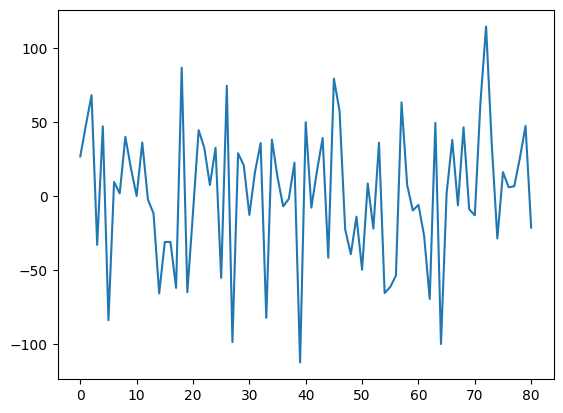

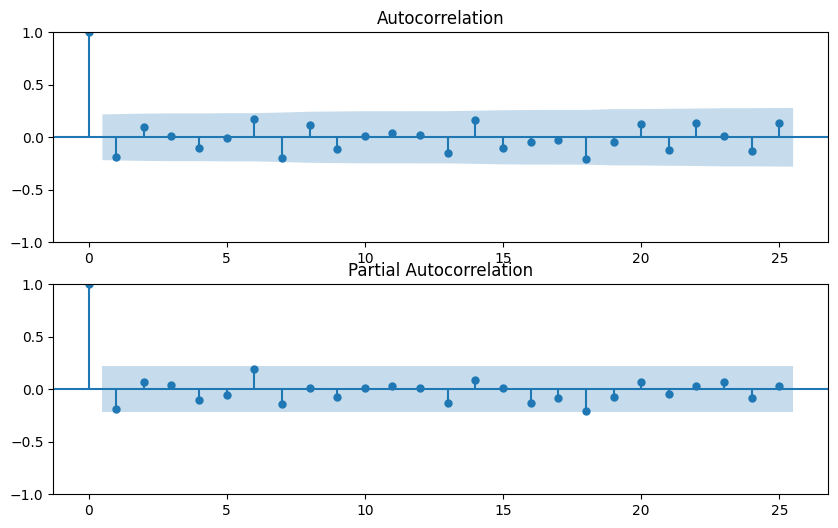

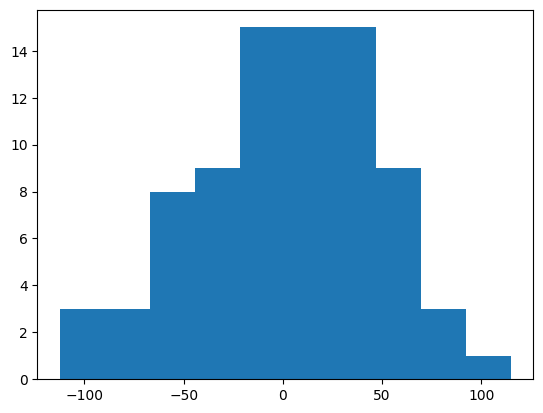

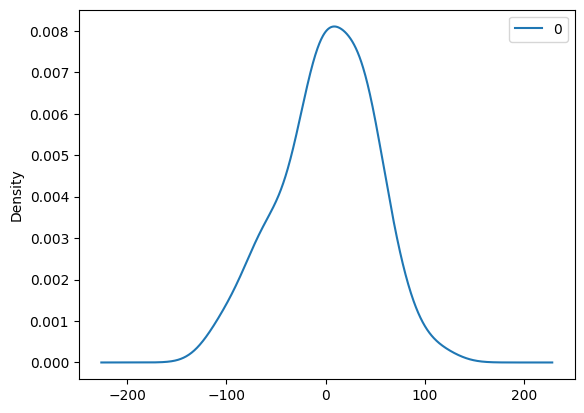

In [103]:
from statsmodels.tsa.arima.model import ARIMA

# Walk forward validation
# With a traditional walk forward validation, we will re-train the ARIMA model at each time step. However this is very
# expensive computational;y, hence we are only going to fit the ARIMA model once.
# We are also going to reduce p = 57 to p = 1 otherwise we will be waiting for hours

# fit model once
history = [x for x in train]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order=(0, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    history.append(test[i])
    predictions.append(yhat)
# calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)
# calculate errors
residuals = [test[i] - predictions[i] for i in range(len(test))]
# Review residuals

# Autocorrelation and partial autocorrelation plots
plt.plot(residuals)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(residuals, lags=25, ax=ax1)
plot_pacf(residuals, lags=25, ax=ax2)
plt.show()

# Histograms
plt.hist(residuals)
residuals = pd.DataFrame(residuals)
residuals.plot(kind='kde')

plt.show()


We have displayed the autoregression, partial autoregression and density plots of the residuals using our ARIMA model. The distribution given by the histogram is roughly Gaussian with slight negative skew. Moreover, both the autocorrelation and partial autocorrelation plots cut off immediately, which shows that there is little to no autocorrelation/partial autocorrelation with residuals at previous time steps. Overall, the residuals resemble Gaussian noise centred around zero, and so the ARIMA(0, 1, 2) model is a good fit for FTSE 100 values as it has captured most of the autocorrelation.

### ARIMA model with Box-Cox transformed FTSE 100 values
We can apply a power transform to the FTSE 100 values to make the distribution of values more Gaussian. Examples of power transforms include log, square root and reciprocal transforms. The Box-Cox transform is able to evaluate a variety of power transforms, selecting the one that best removes the trend component of the time series.

lambda: -2.9216475036942775


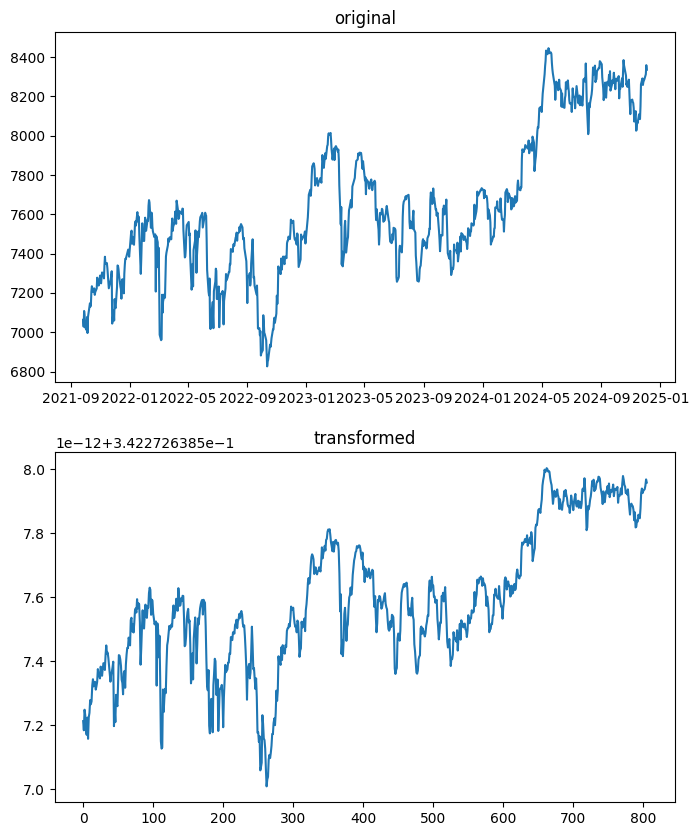

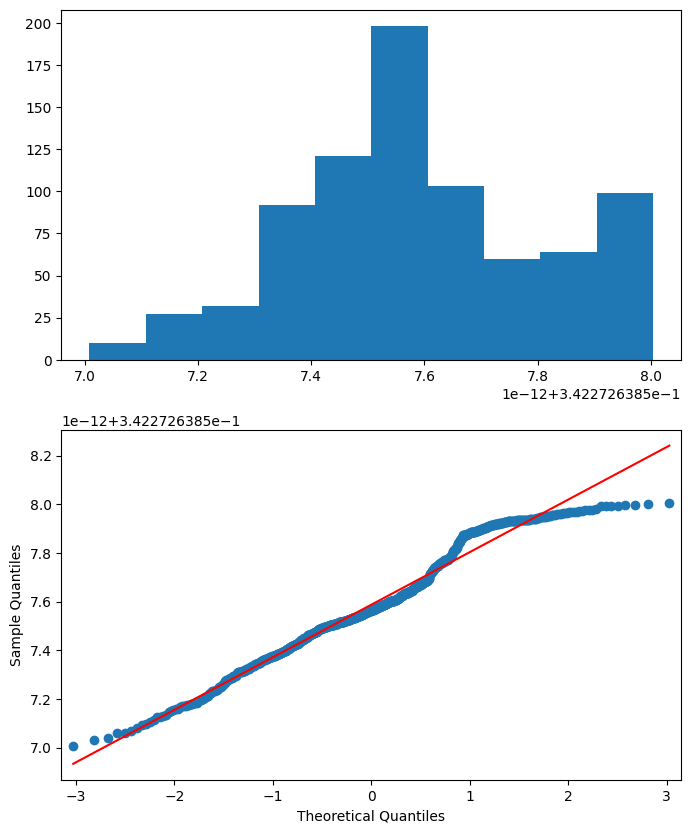

In [129]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import boxcox
# Transforming closing FTSE 100 values
transformed, lam= boxcox(FTSE_100_closing_series)

print(f'lambda: {lam}')

# transformed vs original plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
ax1.plot(FTSE_100_closing_series)
ax1.set_title('original')
ax2.plot(transformed)
ax2.set_title('transformed')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
ax1.hist(transformed)
qqplot(transformed, line='r', ax=ax2)

plt.show()

# Histograms and Q-Q plots



We can define a function that applies the inverse Box-Cox transform to the data, using the following information.<br>

$transform = log(x)$,  if $\lambda = 0$ <br>
$transform = \frac{x^{\lambda}-1}{\lambda}$ otherwise

In [130]:
from math import log
from math import exp
def boxcox_inverse(value, lam):
    return exp(value) if lam == 0 else exp(log(lam * value + 1) / lam)


We can re-evaluate the ARIMA(0, 1, 2) model with the BOX-COX transform, this first requires us to transform the history prior to fitting the ARIMA model, then inverting the transform on the prediction before storing it for later comparison with expected values.



In [138]:
# Walk forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # transform history using boxcox
    transformed = boxcox(history, lmbda = lam)
    # predict next time step value (transformed)
    model = ARIMA(transformed, order=(0, 1, 2))
    model_fit = model.fit()
    yhat_transformed = model_fit.forecast()[0]
    # invert yhat_transformed
    yhat = boxcox_inverse(yhat_transformed, lam)
    predictions.append(yhat)
    # observation added to history
    history.append(test[i])
rmse = sqrt(mean_squared_error(test, predictions))



c:\Users\samue\OneDrive\Desktop\Principles_of_Programming\BYD_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samue\OneDrive\Desktop\Principles_of_Programming\BYD_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samue\OneDrive\Desktop\Principles_of_Programming\BYD_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\samue\OneDrive\Desktop\Principles_of_Programming\BYD_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

We'll use the ARIMA(0, 1, 2) model as the final model

### Validating our ARIMA(0, 1, 2) model

We first need to finalize the model. This means applying it to all the FTSE 100 values which haven't been set aside for validating. We fit the ARIMA model with this data as follows:

In [ ]:
model = ARIMA(FTSE_100_closing_series.values, order=(0, 1, 2))
model_fit = model.fit()   
       

We then validate our chosen model using the FTSE_100_validation. We make predictions in a rolling forecast manner.

<class 'pandas.core.frame.DataFrame'>
Predicted = 9206.80899095461, Expected = 8349.400390625


C:\Users\samue\AppData\Local\Temp\ipykernel_46012\2944292724.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(validation_values[0])
C:\Users\samue\AppData\Local\Temp\ipykernel_46012\2944292724.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Predicted = {yhat}, Expected = {validation_values[0]}')
C:\Users\samue\AppData\Local\Temp\ipykernel_46012\2944292724.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

RMSE: 91.24791426914088


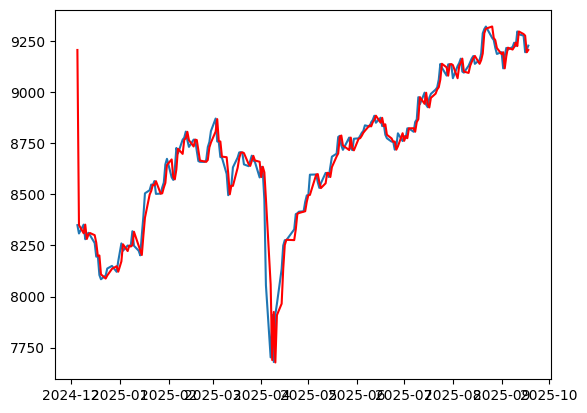

In [157]:
print(type(FTSE_100_validation))
validation_values = FTSE_100_validation['Close']
# history set
history = [x for x in FTSE_100_closing_series]
# making first prediction
predictions = []
yhat = model_fit.forecast()[0]
history.append(validation_values[0])
print(f'Predicted = {yhat}, Expected = {validation_values[0]}')
predictions.append(yhat)
# Make a rolling forecast
for i in range(1, len(validation_values)):
    # predict
    model = ARIMA(history, order=(0, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(validation_values[i])
# report performance
rmse = sqrt(mean_squared_error(validation_values, predictions))
print(f'RMSE: {rmse}')

# add time index to predictions
predictions_df = pd.DataFrame(predictions)
predictions_df.index = FTSE_100_validation.index
plt.plot(validation_values)
plt.plot(predictions_df, color='red')
plt.show()



